In [1]:
import numpy as np
import matplotlib.pyplot as plt
from htmresearch.support.gridcells.context_integration.context_layer import ContextLayer
from htmresearch.support.gridcells.context_integration.utils import create_module_shape
from scipy.stats import entropy
%matplotlib inline
%load_ext autoreload
%autoreload 2


# Hyper-module
m = 10
n = 30

module_shapes = create_module_shape(m,n)
c =  np.sum([ np.prod(module_shapes[i])  for i in range(m)  ])
# Layer
d = 20

l =  c//d + c%d
layer_shape  = (d, c//d + c%d)
print layer_shape
zero = np.zeros(2*m)
dx   = np.zeros(2*m)
dy   = np.zeros(2*m)

dx[0:2] = np.array([1,0])
dy[0:2] = np.array([0,1])

action_tensor = np.zeros((m, 2, 2*m))
for i in range(m):
    theta = np.random.sample()*np.pi*2
    sixty = np.pi/3 + np.random.randn()*0.0
    s1     = 3 + np.random.sample()*3
#     s2     = 3 + np.random.sample()*5.
    
    action_tensor[i,:,0:2] = np.array([
        [ s1*np.cos(theta), s1*np.cos(theta + sixty)],
        [ s1*np.sin(theta), s1*np.sin(theta + sixty)]  
    ]).astype(int)
    
print dx
print np.dot(action_tensor[0,:,:], dx)
print action_tensor[0,:,:5]
print action_tensor[1,:,:5]

(20, 426)
[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.]
[ 0.  4.]
[[ 0. -3.  0.  0.  0.]
 [ 4.  2.  0.  0.  0.]]
[[ 2.  5.  0.  0.  0.]
 [-5.  0.  0.  0.  0.]]


In [2]:
"""
Creating a 
binary code for features.
"""
def encode(digit, l, w=4):
    start = digit * l/10
    end = start + w
    return [ i%l for i in range(start, end)]

w = 5
F = np.zeros((10,d,l))
for i in range(10):
    F[i,:,encode(i%10, l, w)] = 1
    
print F[i].shape
print "Pattern weight:", w*d
print "Sparsity (bottom up):", float(w)/l


CL  = ContextLayer(layer_height=d, module_shapes=module_shapes, action_map = action_tensor, max_activity=(d*w)*10) 

print CL

(20, 426)
Pattern weight: 100
Sparsity (bottom up): 0.0117370892019
**Context Layer:**
Number of cells:	 8520
Layer Shape:		 (20, 426)
Hyper-Module Shape:	 [[28 31]
 [26 30]
 [33 27]
 [34 28]
 [26 27]
 [28 30]
 [33 28]
 [27 28]
 [29 31]
 [30 29]]
Module bounds: [   0  868 1648 2539 3491 4193 5033 5957 6713 7612 8482]
Activity bound:		 1000


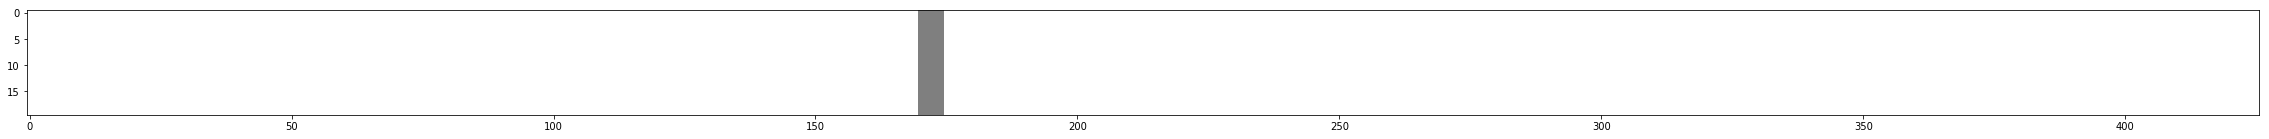

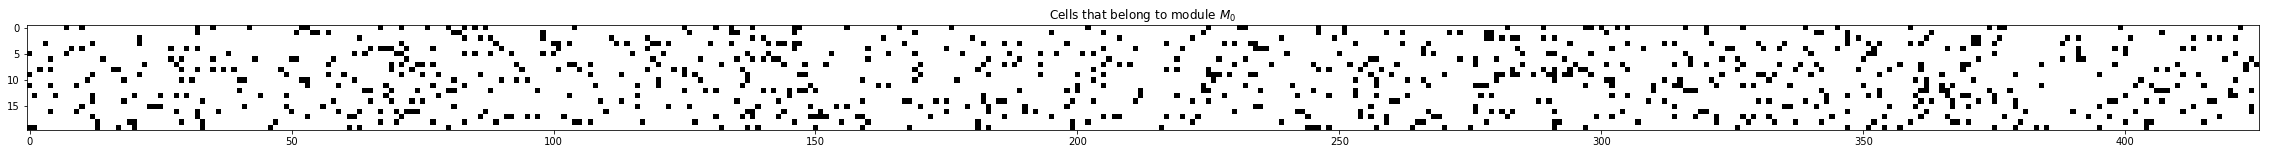

In [9]:
CL.clear()



plt.figure(figsize=(40,20))
plt.imshow(0.5*F[4], cmap="binary", vmin=0, vmax=1)
plt.show()

plt.figure(figsize=(40,20))
plt.title("Cells that belong to module $M_0$")

plt.imshow(CL.highlight_module(0), cmap="binary", vmin=0, vmax=1)
# plt.title("Unused cells, i.e. those not mapped to a grid cell module")
# plt.imshow(CL.highlight_unused_states(), cmap="binary", vmin=0, vmax=1)

CL.clear()

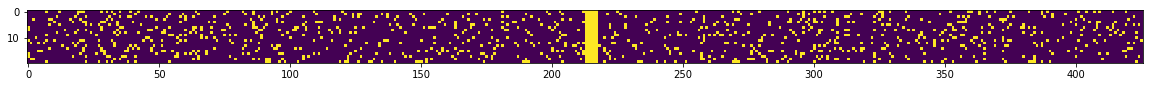

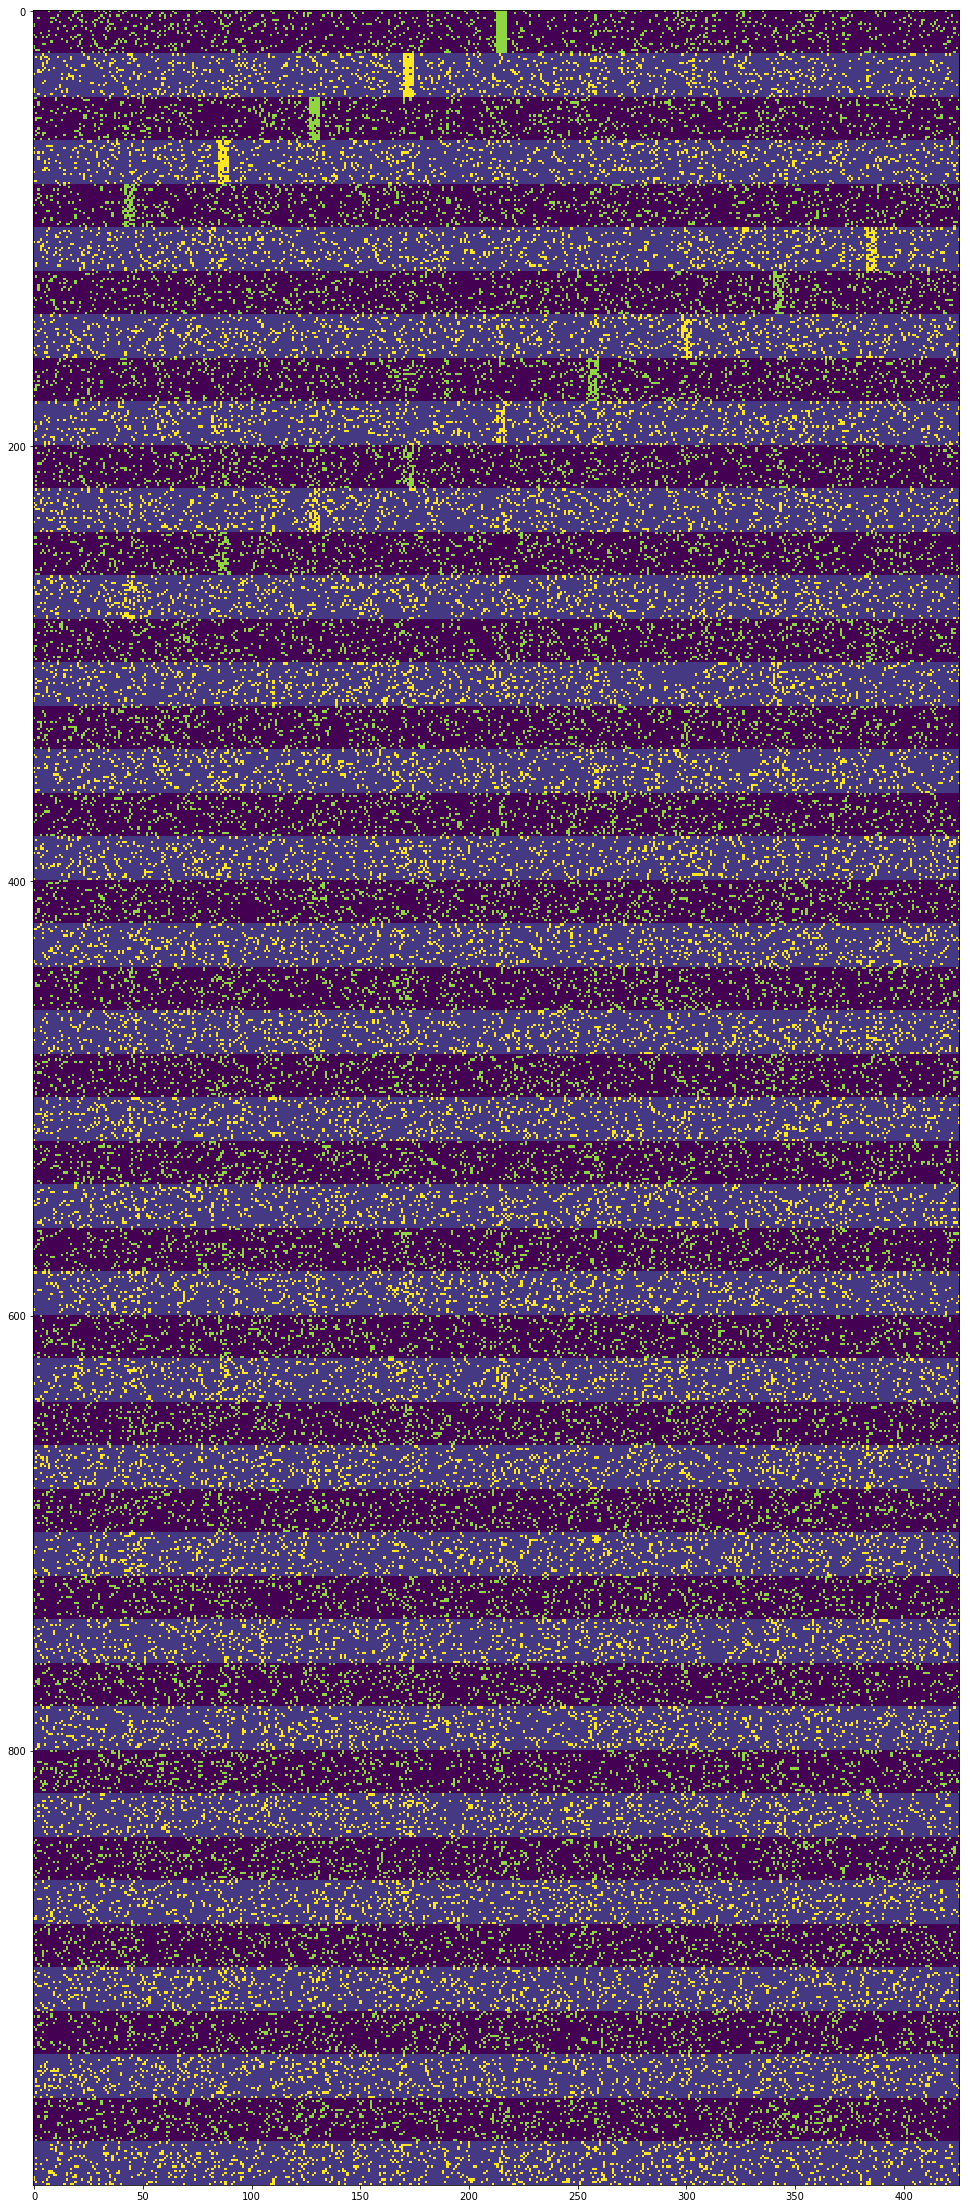

In [4]:
CL.clear()
CL.extend(zero, F[0])
T = 500
for t in range(T):
    CL.extend(dx , F[1 + t%9])

plt.figure(figsize=(20,10))
plt.imshow(CL.layer)
plt.show()

plt.figure(figsize=(40,40))
img = np.concatenate([CL.explore(-t*dx, mentally=True) + (t%2)*0.2 for t in range(0,50)], axis=0)
# plt.imshow(img, cmap="viridis", vmin=0, vmax=1)
plt.imshow(img, cmap="viridis")
plt.show()
    

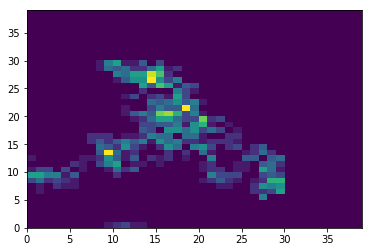

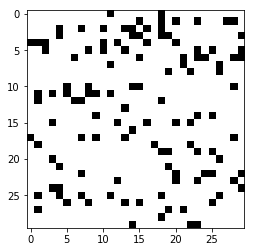

In [5]:
"""
Creating an environment and 
a path of an agent
"""
from htmresearch.support.gridcells.random_walk import smooth_torus_walk

env = np.zeros((30,30))
env = (np.random.sample(env.shape) > 0.86).astype(float)

num_steps = 100000
X, _ = smooth_torus_walk(num_steps, start=[0.5,0.5], min_speed=0.02, max_speed=0.055, sigma=12.5)

X[:,0] *= (env.shape[0] )
X[:,1] *= (env.shape[1] )
X = X.astype(int)

V = np.zeros(X.shape)
for t in range( X.shape[0] - 1):
    V[t,:] = X[t+1] - X[t] 

plt.xlim(0., env.shape[1]);
plt.ylim(0., env.shape[0]);
plt.hist2d(X[0:1000,1],X[0:1000,0], bins=np.arange(40));
plt.show()   
plt.imshow(env , cmap="binary", vmin=0, vmax=1)
plt.show()

number of features visited: 67


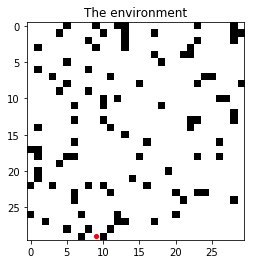

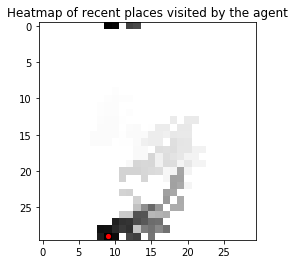

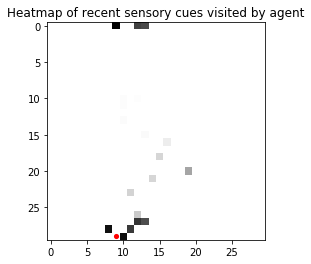

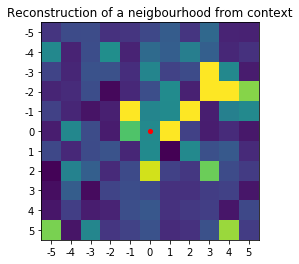

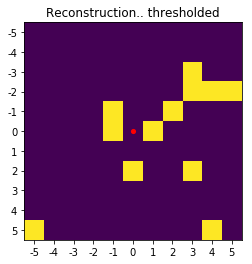

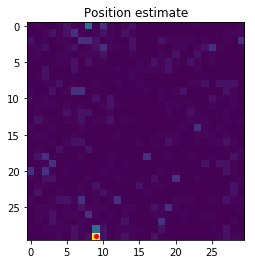

In [7]:
from htmresearch.support.gridcells.context_integration.utils import create_env_nbh_tensor, position_estimate, diffusion


env = (np.random.sample(env.shape) < 0.1).astype(float)
CL  = ContextLayer(layer_height=d, module_shapes=module_shapes, action_map = action_tensor, max_activity=(d*w)*20) 

r = 5

nbh_tensor = create_env_nbh_tensor(env, r)







T = 50
heatmap_agent = np.zeros(env.shape)
    
movie_frames = []

count = 0
for t in range(0,500):
#     if t%10==0:
#         print t
        
        
    CL.explore(V[t,0]*dx + V[t,1]*dy)
    
    pos = X[t+1] 
    
    heatmap_agent *= 0.99
    heatmap_agent[pos[0],pos[1]] = 1
    
    f_id = int(env[pos[0],pos[1]] )
    if f_id > 0:
        count += 1
        CL.extend(zero, F[ f_id ])
    
#     nbh = CL.decode_bw(r, threshold=0.7, softmax=True)
#     prob = position_estimate(nbh_tensor, nbh, r )
#     movie_frames.append(diffusion(prob))
        
print "number of features visited:", count

plt.title("The environment")
plt.imshow(env, cmap="binary", vmin=0, vmax=1)
plt.scatter(X[t+1,1],X[t+1,0], s=10, marker="o", c="red", edgecolor='red',  lw = 2)
plt.show()

plt.title("Heatmap of recent places visited by the agent")
plt.imshow(heatmap_agent, cmap="binary", vmin=0, vmax=1)
plt.scatter(X[t+1,1],X[t+1,0], s=10, marker="o", c="red", edgecolor='red',  lw = 2)
plt.show()

plt.title("Heatmap of recent sensory cues visited by agent")
plt.imshow(heatmap_agent*env, cmap="binary", vmin=0, vmax=1)
plt.scatter(X[t+1,1],X[t+1,0], s=10, marker="o", c="red", edgecolor='red',  lw = 2)
plt.show()


nbh = CL.decode_bw(r, softmax=True)

plt.title("Reconstruction of a neigbourhood from context")
plt.imshow(nbh)
plt.scatter(r,r, s=10, marker="o", c="red", edgecolor='red',  lw = 2)
plt.xticks(range(2*r +1), range(-r, r+1))
plt.yticks(range(2*r +1), range(-r, r+1))
plt.show()


nbh = CL.decode_bw(r, threshold=0.7, softmax=True)



plt.title("Reconstruction.. thresholded")
plt.imshow(nbh)
plt.scatter(r,r, s=10, marker="o", c="red", edgecolor='red',  lw = 2)
plt.xticks(range(2*r +1), range(-r, r+1))
plt.yticks(range(2*r +1), range(-r, r+1))
plt.show()


prob = position_estimate(nbh_tensor, nbh, r )


plt.title("Position estimate")
plt.imshow(prob)
plt.scatter(X[t+1,1],X[t+1,0], s=10, marker="o", c="red", edgecolor='red',  lw = 2)
plt.show()

# plt.hist2d(X[2500:2600,1],X[2500:2600,0], bins=np.arange(40));
# plt.show()  
# for t in range(0,100):
#     CL.explore(V[t].astype(int))
#     pos = X[t+1] 
#     if t%20==0:
#         print t
#     heatmap_agent *= 0.99
#     heatmap_agent[pos[0],pos[1]] = 1
    
#     f_id = int(env[pos[0],pos[1]] )
#     if f_id > 0:
#         CL.extend([0,0], F[ f_id ])
    
#     prob = position_estimate(CL, env_tensor)
#     movie_frames.append(prob)
        
# plt.imshow(- env + 6*(env * heatmap_agent), cmap="binary", vmin=0, vmax=5)
# plt.scatter(X[t+1,1],X[t+1,0], s=10, marker="o", c="red", edgecolor='red',  lw = 2)
# plt.show()

# # plt.figure(figsize=(10,10))
# plt.imshow(env, cmap="binary", vmin=0, vmax=1)
# plt.scatter(X[t+1,1],X[t+1,0], s=10, marker="o", c="red", edgecolor='red',  lw = 2)
# plt.show()

# mask = CL.decode_bw(10)
# mask = mask - np.amin(mask)
# if np.amax(mask) > 0:
#     mask = mask/np.amax(mask)
# # mask = (mask > 0.8).astype(float)
# plt.imshow(mask)
# plt.show()

# prob = position_estimate(CL, env_tensor)

# # plt.imshow(prob, cmap='binary', interpolation='bicubic')
# plt.imshow(prob, cmap='binary', interpolation='none')
# plt.scatter(X[t+1,1],X[t+1,0], s=250, marker="^", c="none", edgecolor='red',  lw = 2)
# plt.show()



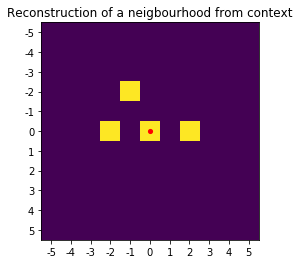

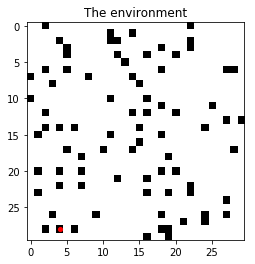

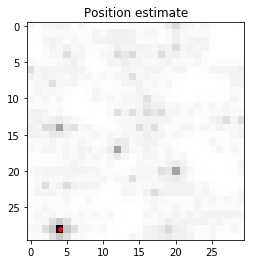

In [331]:




nbh = CL.decode_bw(r,threshold=0.8, softmax=True)

plt.title("Reconstruction of a neigbourhood from context")
plt.imshow(nbh)
plt.scatter(r,r, s=10, marker="o", c="red", edgecolor='red',  lw = 2)
plt.xticks(range(2*r +1), range(-r, r+1))
plt.yticks(range(2*r +1), range(-r, r+1))
plt.show()

plt.title("The environment")
plt.imshow(env, cmap='binary', interpolation='none')
plt.scatter(X[t+1,1],X[t+1,0], s=10, marker="o", c="red", edgecolor='red',  lw = 2)
plt.show()


prob = position_estimate(nbh_tensor, nbh, r )
# img = prob
img = diffusion(prob)
plt.title("Position estimate")
plt.imshow(img, cmap='binary', interpolation='none')
plt.scatter(X[t+1,1],X[t+1,0], s=10, marker="o", c="red", edgecolor='red',  lw = 2)
plt.show()

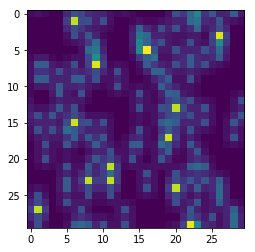

In [334]:
import matplotlib.animation as manimation



filename = "test.html"
title = "test"
fps=15
dpi=100

FFMpegWriter = manimation.writers['html']
metadata = dict(title='Movie Test', artist='Matplotlib',
            comment='Movie support!')
metadata     = dict(title=title)
writer       = FFMpegWriter(fps=fps, metadata=metadata)
fig = plt.figure()

with writer.saving(fig, filename, dpi):
    for s in range(len(movie_frames)):
        plt.imshow(movie_frames[s])
        writer.grab_frame()





6.49185309633
6.49185309633
